In [28]:
import igraph as ig
import math
#import pixiedust

In [102]:
#file = "/home/imane/Desktop/PFE2020/file/Test_Files/Dolphin.gml"
#file = "/home/imane/Desktop/PFE2020/file/Test_Files/karate.gml"
#file = "/home/imane/Desktop/PFE2020/file/Test_Files/football.gml"
file = "/home/imane/Desktop/PFE2020/file/Test_Files/Polbooks.gml"
#file = "/home/imane/Desktop/PFE2020/file/Presentation examples/Example2.gml"

In [103]:
def createGraph(file):
    mainGraph = ig.Graph()
    mainGraph = ig.load(file)
    return mainGraph

def drawGraph(graph):
    graph.vs["vertex_size"] = 100
    graph.vs["label"] = graph.vs["name"]
    graph.vs["color"] = "teal"
    layout = graph.layout("large")
    return ig.plot(graph, bbox = (400, 400), layout = layout,margin = 20, vertex_size = 25, vertex_label_color = "black")

In [104]:
print(math.floor(4.7))

4


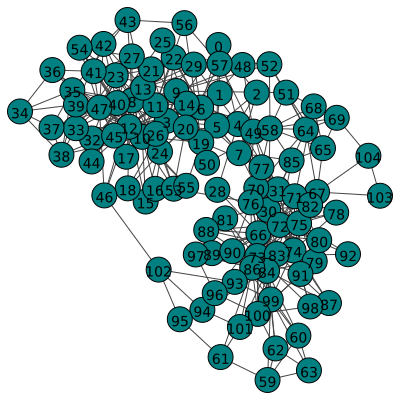

In [105]:
graph = createGraph(file)
drawGraph(graph)

In [106]:
print(graph.vcount())
print(graph.ecount())

105
441


<center> <h1>  STAGE ONE </h1>

<center> <h2>  Central Nodes Identification </h2>

</br>

In [107]:
def rank_nodes(graph):
    degrees_dict = {}
    keys = graph.vs["name"]
    for name in keys:
        degrees_dict[name] = graph.degree(name, loops=False)
    degrees_dict = {name: value for name, value in sorted(degrees_dict.items(), key=lambda item: item[1], reverse = True)}
    #print(degrees_dict)
    return degrees_dict

In [108]:
def sum_distances(graph):
    sum_dist= 0
    for i in range(graph.vcount()-1):
        for j in range(i+1, graph.vcount()):
            sum_dist = sum_dist + graph.shortest_paths_dijkstra(i, j)[0][0]
    return sum_dist

def avg_dist_D(graph):
    n = graph.vcount()
    return math.floor(2/(n*(n - 1)) * sum_distances(graph))

In [109]:
def check(L, D, key):
    return(all(graph.shortest_paths_dijkstra(key, k)[0][0] >= D for k, v in L)) 
   
def central_nodes_set(graph, degrees_dict, avg_dist):
    cent_node_set = {}
    remaining_nodes = {}

    cent_node_set[list(degrees_dict.keys())[0]] = list(degrees_dict.values())[0]
    degrees_dict.pop(list(degrees_dict.keys())[0], None)
    
    for key, value in list(degrees_dict.items()):           
        if check(list(cent_node_set.items()), avg_dist, key):
            cent_node_set[key] = degrees_dict[key]
            del degrees_dict[key]
        else:
            remaining_nodes[key] = degrees_dict[key]
            del degrees_dict[key]
            
    return cent_node_set, remaining_nodes

In [110]:
def stage_one(graph):
    degrees_dict = rank_nodes(graph)
    D = avg_dist_D(graph)
    return central_nodes_set(graph, degrees_dict, D)

<center> <h1>  STAGE TWO </h1>

<center> <h2>  Label propagation </h2>

<br>

In [111]:
from collections import defaultdict
import random

In [112]:
def init_comm_set(cns, remaining_nodes):
    initial_community = defaultdict(list)
    i = 0
    for key in cns:
        initial_community[i] = [key, ]
        i += 1
    
    remaining_nodes_list = []   
    for key in remaining_nodes:
        remaining_nodes_list.append(key)
        
    return initial_community, remaining_nodes_list

In [113]:
def size_common_neighbors(l1, l2):
    l1_set = set(l1)
    intersection = l1_set.intersection(l2)
    return len(list(intersection))

def sim(u, v):
    numerator = 2 * size_common_neighbors(graph.neighbors(u), graph.neighbors(v))
    denominator = graph.degree(u) + graph.degree(v)
    return(numerator/denominator)

In [114]:
def max_similarity_neighbor(graph, central_node, remaining_nodes_list):
    max_value = 0
    similarity_values = {}
    neighbors_list = graph.neighbors(central_node)
    
    for rn in remaining_nodes_list:
        if int(rn) in neighbors_list:  
            similarity_values[rn] = sim(central_node, rn)            
            #print("similarity_values[rn]", similarity_values[rn], "central_node: ", central_node, "rn: ", rn)
    if len(similarity_values) == 0:
        return False, False
   
    max_value = max(list(similarity_values.values()))
    #print("central node: ", central_node)
    #print("similarity values: ", similarity_values)
    #print("max_value: ", max_value)
    
    for key, value in list(similarity_values.items()):
        if (int(key) in graph.neighbors(central_node)):
            if value != max_value:
                del similarity_values[key]
                
    #print("similarity values after : ", similarity_values)  
    #print()
    random_node = random.choice(list(similarity_values.keys()))
    
    return random_node, similarity_values[random_node]    

In [115]:
def get_key(dictionary, value):
    for k, v in list(dictionary.items()):
        for n in v:
            if n == value:
                return k 

In [116]:
def update_init_community(graph, initial_community, remaining_nodes_list):
      
    while len(remaining_nodes_list) > 0:
        similar_neighbors = {}
        max_val = 0
        k = 0
        for list_nodes in list(initial_community.values()):            
            for node in list_nodes:
                k = 0
                rn, similarity = max_similarity_neighbor(graph, node, remaining_nodes_list)  
                #print("node: ", node,"rn: ", rn, " similarity: ", similarity)
                if rn == False:
                    k = -1
                    continue
                
                if k == -1:
                    break
                    
                similar_neighbors[node] = [rn, similarity]
                
                if max_val < similarity:
                    max_val = similarity
            
        i = 0
        for key, value in list(similar_neighbors.items()):
            if value[1] != max_val:
                del similar_neighbors[key]
            i += 1    
        #print("before: ", initial_community)
        random_n = random.choice(list(similar_neighbors.items()))       
        key_node = get_key(initial_community, random_n[0])
        initial_community[key_node].append(random_n[1][0])
        remaining_nodes_list.remove(random_n[1][0])
        #print("after: ", initial_community)
        #print("---------------------------")
        #print()
    
    return initial_community

In [117]:
def Stage_two(cns, remaining_nodes):
    init_comm_dict, remaining_nodes_list = init_comm_set(cns, remaining_nodes)
    pre_community = update_init_community(graph, init_comm_dict, remaining_nodes_list)
    return pre_community

In [118]:
cns, remaining_nodes = stage_one(graph)
print("cns: ", cns)
print()
print("remaining_nodes: ", remaining_nodes)

cns:  {'8': 25, '84': 23, '65': 7, '2': 4}

remaining_nodes:  {'12': 25, '3': 23, '72': 22, '66': 21, '73': 21, '30': 20, '11': 18, '40': 18, '47': 18, '9': 16, '74': 16, '75': 16, '10': 15, '71': 15, '86': 14, '13': 13, '58': 13, '76': 13, '99': 12, '100': 12, '6': 11, '31': 11, '20': 10, '35': 10, '14': 9, '23': 9, '24': 9, '26': 9, '27': 9, '33': 9, '64': 9, '82': 9, '4': 8, '7': 8, '39': 8, '41': 8, '49': 8, '79': 8, '83': 8, '91': 8, '5': 7, '22': 7, '37': 7, '38': 7, '70': 7, '77': 7, '93': 7, '94': 7, '0': 6, '42': 6, '45': 6, '51': 6, '54': 6, '60': 6, '62': 6, '67': 6, '89': 6, '96': 6, '97': 6, '15': 5, '17': 5, '19': 5, '21': 5, '25': 5, '32': 5, '34': 5, '36': 5, '43': 5, '44': 5, '52': 5, '53': 5, '57': 5, '59': 5, '69': 5, '78': 5, '85': 5, '87': 5, '88': 5, '90': 5, '98': 5, '101': 5, '1': 4, '29': 4, '46': 4, '48': 4, '55': 4, '56': 4, '61': 4, '63': 4, '68': 4, '80': 4, '81': 4, '95': 4, '102': 4, '16': 3, '18': 3, '28': 3, '50': 3, '92': 3, '104': 3, '103': 2}


In [119]:
initial_community, remaining_nodes_list = init_comm_set(cns, remaining_nodes)
print(initial_community)
pre_community = Stage_two(cns, remaining_nodes_list)
print(pre_community)

defaultdict(<class 'list'>, {0: ['8'], 1: ['84'], 2: ['65'], 3: ['2']})
defaultdict(<class 'list'>, {0: ['8', '12', '47', '11', '3', '40', '9', '41', '27', '54', '20', '24', '26', '45', '10', '38', '39', '37', '33', '34', '35', '23', '53', '32', '48', '49', '57', '13', '17', '42', '15', '16', '55', '14', '43', '44', '36', '21', '19', '22', '25', '18', '46', '50', '56'], 1: ['84', '73', '86', '66', '72', '74', '75', '71', '82', '31', '30', '76', '100', '79', '91', '99', '62', '60', '63', '59', '83', '89', '88', '77', '97', '96', '81', '78', '93', '101', '98', '94', '102', '95', '70', '90', '87', '61', '92', '80', '28'], 2: ['65', '64', '51', '69', '52', '58', '68', '7', '67', '103', '104', '85'], 3: ['2', '5', '0', '1', '6', '4', '29']})


 <center> <h1>  STAGE THREE </h1>

<center> <h2>  Community combination </h2>

In [120]:
m = 0.5 * (graph.ecount())
print(m)
adj = graph.get_adjacency()

220.5


In [126]:
def somme_Q(pre_c, i, j):
    k1 = get_key(pre_c, i)
    k2 = get_key(pre_c, j)
    
    if k1 == k2:
        delta = 1
    else: 
        delta = 0
    #print("i: ", i, "j: ", j)
    #print(adj[int(i)][int(j)], " - ", "(", (graph.degree(i), "*", graph.degree(j),") / ", "(", 2, "*", m, ")", " * " , delta))     
    return (adj[int(i)][int(j)] - (((graph.degree(i) * graph.degree(j))/(2 * m)))) * delta

In [127]:
def calculate_modularity(pre_c, combination):
    somme = 0  
    for i in combination:
        for j in combination:            
            somme += somme_Q(pre_c, i, j)
    return (1/(2*m))*somme

In [123]:
def merging_communities(pre_c, old_modularity_value):     
    saved_prec_status = pre_c
    merged_keys = []
    Q_max = 0
    i = 0
    count = 0
    Q_value = 0
    for key in pre_c:
        combination = []
        for v in pre_c[key]:
            combination.append(v)
            
        for k in range(i+1, len(pre_c)):
            for v2 in pre_c[k]:
                combination.append(v2)
            
            #print("combination: ", combination)
            Q_value = calculate_modularity(pre_c, combination)
            print("Q_value: ", Q_value)
            if Q_value > 0:
                if Q_value > Q_max:
                    if len(merged_keys) > 0:
                        merged_keys = []                       
                    merged_keys.append(key)
                    merged_keys.append(k)
                    
            count += 1
            if count == (len(pre_c) - 1):
                i = len(pre_c)
        #print("pre_c: ", pre_c)
                      
    if len(merged_keys) > 0:  
        print("merged keys: ", merged_keys)
        for v in pre_c[merged_keys[1]]:
            pre_c[merged_keys[0]].append(v)
        del pre_c[merged_keys[1]]
        
    
        
    #if old_modularity_value >= Q_value:
    #    return saved_prec_status, old_modularity_value

        
        
           
    return pre_c, Q_value    

In [124]:
def pre_community_optimization(pre_c):
    modularity = 0
    old_modularity_value = 0
    current_modularity_value = 0
    decision = True
    
    while decision == True:
        old_modularity_value = current_modularity_value
        old_prec = pre_c
        new_pre_c, current_modularity_value = merging_communities(pre_c, old_modularity_value)
        pre_c = new_pre_c
        print("old_modularity_value: ", old_modularity_value)
        print("curr_modularity_value: ", current_modularity_value)
        print("in")
        if old_modularity_value >= current_modularity_value:
            decision = False
            break

        
        
    print("Modularity: ", old_modularity_value)    
    return old_prec

In [125]:
pre_community_optimization(pre_community)

Q_value:  0.13147299736221002
Q_value:  0.22198569526071935
Q_value:  0.27552305880780087
merged keys:  [0, 3]
old_modularity_value:  0
curr_modularity_value:  0.27552305880780087
in
Q_value:  0.05253469490592922
Q_value:  0.1430473928044385
merged keys:  [0, 2]
old_modularity_value:  0.27552305880780087
curr_modularity_value:  0.1430473928044385
in
Modularity:  0.27552305880780087


defaultdict(list,
            {0: ['8',
              '12',
              '47',
              '11',
              '3',
              '40',
              '9',
              '41',
              '27',
              '54',
              '20',
              '24',
              '26',
              '45',
              '10',
              '38',
              '39',
              '37',
              '33',
              '34',
              '35',
              '23',
              '53',
              '32',
              '48',
              '49',
              '57',
              '13',
              '17',
              '42',
              '15',
              '16',
              '55',
              '14',
              '43',
              '44',
              '36',
              '21',
              '19',
              '22',
              '25',
              '18',
              '46',
              '50',
              '56',
              '2',
              '5',
              '0',
              '1',
      

<b> Previous code: <b/>

In [100]:
while len(degrees_dict) > 0:
    
    max_cn, max_n = max_similarity_node(graph, cns, degrees_dict)
    key = get_key(init_comm_dict, max_cn)
    print("")
    print("key: ",key)
    print("")
    init_comm_dict[key].append(max_n)
    print(init_comm_dict)
    print("")

    cns[max_n] = degrees_dict[max_n]
    print("")
    print("cns: ", cns)
    print("")
    del degrees_dict[max_n]


print(degrees_dict)
print(init_comm_dict)

def max_similarity_node(graph, cns, degrees_dict):
    max_cn = ""
    max_sim = -1
    for c in cns:
        similarity = 0
        for n in degrees_dict:
            neighbors = graph.neighbors(c)  
            print("")
            print("v: ", c, " u: ", n)
            print("")
            if int(n) in neighbors:
                print("")
                similarity = sim(c, n)
                print("similarity: ", similarity, " between ", c," and ", n)
                print("")
            if similarity > max_sim:
                max_cn = c
                max_n = n
                max_sim = similarity
    print("")
    print("max_cn: ", max_cn)
    print("")
    print("max_n: ", max_n)
    print("")
    print("max_sim: ", max_sim)
    print("")
    return max_cn, max_n

def get_key(init_comm_dict, max_cn):
    for k in init_comm_dict:
        for i in range(len(init_comm_dict[k])):
            if max_cn == init_comm_dict[k][i]:
                return k

NameError: name 'degrees_dict' is not defined

In [ ]:
init_comm_dict, remaining_nodes_list = init_comm_set(cns, remaining_nodes)
print(init_comm_dict)
pre_community = update_init_community(graph, initial_community, remaining_nodes_list)
print(pre_community)

In [62]:
l = defaultdict(list)
l = {1: ['1', '2'], 2: ['3', '4']}

for v in l[2]:
    l[1].append(v)
print(l)    

{1: ['1', '2', '3', '4'], 2: ['3', '4']}
